In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import keras
import PIL

import keras.backend as K
from tensorflow.python.framework import ops

from scipy import ndimage
import copy

from collections import OrderedDict

import sys
sys.path.append("DeepDanbooru")

import deepdanbooru as dd

import pickle
import glob
import time

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import clear_output

Using TensorFlow backend.


In [2]:
# Unlike stylegan2, deepdanbooru wishes to use tf2. backporting might be possible, but is likely a pain.
print(tf.__version__)

2.1.0


In [3]:
##
# First, load the model
##
# Pretrained model can be downloaded here:
# https://github.com/KichangKim/DeepDanbooru/releases/download/v3-20200101-sgd-e30/deepdanbooru-v3-20200101-sgd-e30.zip
project_path = "deepdanbooru_model/"

classif_model = dd.project.load_model_from_project(project_path)
all_tags = dd.project.load_tags_from_project(project_path)
model_width = classif_model.input_shape[2]
model_height = classif_model.input_shape[1]
all_tags = np.array(all_tags)

In [4]:
##
# Functions for data reading
##
def read_image(image_path):
    image = dd.data.load_image_for_evaluate(image_path, width=model_width, height=model_height)
    image_fullres = PIL.Image.open(image_path).convert('RGB')
    return image_fullres, image

In [5]:
##
# Functions for tag estimation
##
def decode_tags(image_arrays, threshold = 0.1):
    """
    Decode tags using DeepDanbooru, threshold them and return them
    as a sorted dict (highest likelihood first)
    
    Will return a list if a list is passed.
    """
    if len(np.array(image_arrays).shape) == 4:
        return_list = True
    else:
        image_arrays = np.array([image_arrays])
        return_list = False
    
    # Decode
    results = classif_model.predict(image_arrays).reshape(-1, all_tags.shape[0])
    
    # Threshold and sort
    result_list = []
    for result_set in results:
        result_tags = {}
        for i in range(len(all_tags)):
            if result_set[i] > threshold:
                result_tags[all_tags[i]] = result_set[i]
  
        sorted_tags = reversed(sorted(result_tags.keys(), key = lambda x: result_tags[x]))
        sorted_results = OrderedDict()
        for tag in sorted_tags:
            sorted_results[tag] = result_tags[tag]
        result_list.append(sorted_results)
    
    if return_list:
        return result_list
    else:
        return result_list[0] 
    
def show_tags(result_tags):
    """
    Tag list prettyprinter
    """
    for tag in result_tags.keys():
        print('    {0: <32} {1:04f}'.format(tag, result_tags[tag]))
    
def get_likelihood(image_array, tags):
    """
    Decode and return mean likelihood of given tags
    """
    results = decode_tags(image_array, threshold = 0.0)
    sum_likelihood = 0.0
    for tag in tags:
        sum_likelihood += results[tag]
    return sum_likelihood / len(tags)

In [6]:
##
# Gradcam with batching
##
def gradcam(image_array, class_sets, batch_size = 5, verbose = False):
    """
    Get gradient at inputs that maximizes the given class(es)
    """
    results = []
    for batch_start in range(0, len(class_sets), batch_size):
        if verbose:
            print("Batch: {} to {} of {}".format(batch_start, batch_start+batch_size, len(class_sets)))
        batch = class_sets[batch_start:batch_start + batch_size]
        
        batch_size_real = len(batch)
        image_array_feed = np.array([image_array] * batch_size_real)
        image_feed = tf.Variable(image_array_feed)
        
        batch_nhot_list = []
        for classes in batch:
            if not isinstance(classes, list):
                classes = [classes]

            class_nhot = np.zeros(len(all_tags))
            for gradcam_class in classes:
                class_idx = list(all_tags).index(gradcam_class)
                class_nhot[class_idx] = 1.0
            batch_nhot_list.append(class_nhot)
        
        with tf.GradientTape() as tape:
            output = classif_model(image_feed)
            test = tf.multiply(batch_nhot_list, output)
            gradcam_loss = tf.reduce_sum(tf.multiply(batch_nhot_list, output))
            results.extend(list(tape.gradient(gradcam_loss, image_feed)))
    return np.array(results)

In [7]:
##
# Functions for activation map processing
##
def norm_clip_grads(grads):
    """
    Normalize gradcam gradients by clipping them to between the 1st and 
    the 99th percentile, taking the absolute value and then mapping that 
    range to 0 -> 1
    """
    upper_quantile = np.quantile(grads, 0.99)
    lower_quantile = np.quantile(grads, 0.01)
    clipped_grads = np.abs(np.clip(grads, lower_quantile, upper_quantile))
    return clipped_grads / np.max(clipped_grads)

def postprocess_grads(grads, filter_width = 10):
    """
    Normalize gradients, take the mean and apply
    a median filter
    """
    gradcam_map = np.mean(norm_clip_grads(grads), axis = -1)
    return ndimage.median_filter(gradcam_map, filter_width)
 
def threshold_map(gradcam_map, all_maps, filter_width = 10):
    """
    Refine gradcam map by applying a threshold mask that zeroes out
    areas where the map is not bigger than the average of all maps
    (i.e. remove areas that are only "generally interesting" instead
    of interesting for this tag specifically)
    """
    threshold_mask = gradcam_map > np.mean(all_maps, axis = 0)
    return ndimage.median_filter(threshold_mask, filter_width) * gradcam_map

def mask_for_tags(tags, gradcam_maps_processed, clip_value = 0.3, regu_value = 0.0, median_filter_width = 10, anti_tags = None):
    """
    Given tag(s) and a set of (normalized) gradcam maps, generate a mask of pixels
    that contribute to the threshold_map image being assigned those tags
    
    Maps are combined multiplicatively, anti-tags (if specified) are used inversely
    """
    if not isinstance(tags, list):
        tags = [tags]
    
    tags_map = np.ones(gradcam_maps_processed[tags[0]].shape)
    for tag in tags:
        tag_map = threshold_map(gradcam_maps_processed[tag], list(gradcam_maps_processed.values()))
        tag_map = ndimage.median_filter(tag_map, median_filter_width)
        tag_map /= np.max(tag_map)
        tags_map *= tag_map
    
    if not anti_tags is None:
        for tag in anti_tags:
            if tag in gradcam_maps_processed:
                tag_map = threshold_map(gradcam_maps_processed[tag], list(gradcam_maps_processed.values()))
                tag_map = ndimage.median_filter(tag_map, median_filter_width)
                tag_map /= np.max(tag_map)
                tags_map *= (1.0 - tag_map)
            
    tags_map /= np.max(tags_map)
    tags_map = np.maximum(tags_map, clip_value)
    tags_map += regu_value
    tags_map /= np.max(tags_map)
    
    return tags_map

def show_mask(image, mask):
    """
    Show a nice plot of an image, a mask, and the masked image
    """
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.xlabel("Input image")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, vmin = 0.0, vmax = 1.0)
    plt.xlabel("Activation mask")

    plt.subplot(1, 3, 3)
    plt.imshow(image * np.repeat(mask, 3).reshape(image.shape))
    plt.xlabel("Masked image")
    
def plot_tags(image_arr, gradcam_maps_processed, tags, anti_tags = None):
    """
    Get mask for tag and plot
    """
    mask = mask_for_tags(tags, gradcam_maps_processed, 0.2, anti_tags = anti_tags)
    show_mask(image_arr, mask)
    title = "Mask for tags: '{}'".format(" ".join(tags))
    if not anti_tags is None:
        title += " excluding '{}'".format(" ".join(anti_tags))
    plt.suptitle(title)

In [8]:
##
# Postprocessing and masking tools
##
def get_mask_image(gradcam_maps_processed, tags_to_mask, tags_to_keep = None, mask_thresh = 0.2, inverse = False, dilation_scale = 1.0):
    """
    Find a binary tag mask for one or more tags by thresholding and
    dilation/erosion 
    """
    mask = np.zeros(gradcam_maps_processed[list(gradcam_maps_processed.keys())[0]].shape)
    if not isinstance(tags_to_mask, list):
        tags_to_mask = [tags_to_mask]

    tag_set_real = []
    for tag in tags_to_mask:
        if tag in gradcam_maps_processed:
            tag_set_real.append(tag)
            
    if len(tag_set_real) > 0:
        temp_mask = mask_for_tags(tag_set_real, gradcam_maps_processed, 0.0, anti_tags = tags_to_keep) < mask_thresh
        mask += 1.0 - temp_mask
        
    mask = 1.0 - np.clip(mask, 0.0, 1.0)
    if inverse:
        mask = 1.0 - mask
        
    # Do some hole / noise removal and make the mask a tad larger
    mask = ndimage.morphology.binary_dilation(mask, iterations=int(5 * dilation_scale), border_value = 1)
    mask = ndimage.morphology.binary_erosion(mask, iterations=int(15 * dilation_scale), border_value = 1) * 1.0

    return mask

def mask_image_array(image_array, mask):
    """
    Apply a mask to an image array
    """
    return image_array * mask.reshape(mask.shape[0], mask.shape[1], 1).repeat(3, axis = -1)

def find_tuned_mask_image(image_array, gradcam_maps_processed, tags_to_mask, tags_to_keep = None, threshold_factor = 0.25, maximum_likelihood = 1.0):
    """
    Get a mask image and use the classifier to automatically tune the
    threshold for masking by looking for a setting for which the 
    likelihood is under a certain value.
    
    Returns the mask and the determined threshold
    """
    # Figure out at what threshold we should stop
    initial_likelihood = get_likelihood(image_array, tags_to_mask)
    if initial_likelihood < 0.01:
        return np.ones(image_array.shape[0:2]), 1.0
    break_likelihood = min(maximum_likelihood, initial_likelihood * threshold_factor)
    
    # Now run until we go past that and return
    for i in range(0, 70):
        threshold = (70 + 1) * 0.01 - 0.01 * i
        mask = get_mask_image(gradcam_maps_processed, tags_to_mask, tags_to_keep, mask_thresh = threshold)
        likelihood = get_likelihood(mask_image_array(image_array, mask), tags_to_mask)
        if likelihood < break_likelihood:
            break
    return mask, threshold

In [9]:
##
# Full-image masking tools (with pixelation for fun. christian anime websites: call me)
# All of these are uneccesarily complicated and could be simplified a lot, probably
##
def mask_fullres_image(image_fullres, image_array, gradcam_maps_processed, tags_to_mask, tags_to_keep = None, inverse = False, pixelate = True, dilation_scale = 1.0):
    """
    Find a tag mask and apply it to a full-resolution image (either blacking 
    out or pixelating regions)
    
    This is a bit slow, but should be fairly automatic
    """
    # Get a combined (additive) mask for these tags
    mask = np.zeros(gradcam_maps_processed[list(gradcam_maps_processed.keys())[0]].shape)
    for tag_set in tags_to_mask:
        if not isinstance(tag_set, list):
            tag_set = [tag_set]
        tmp_mask, _ = find_tuned_mask_image(image_array, gradcam_maps_processed, tag_set, tags_to_keep)
        mask += 1.0 - tmp_mask
    mask = np.clip(mask, 0.0, 1.0)
    if not inverse:
        mask = 1.0 - mask
        
    # Scale mask to image size
    mask_image = np.repeat(mask.reshape(mask.shape[0], mask.shape[1], 1), 3, axis = -1) * 255.0
    mask_image = PIL.Image.fromarray(mask_image.astype("uint8"))
    mask_image = mask_image.resize(image_fullres.size, resample = PIL.Image.LANCZOS)

    # Gauss filter to make everything look nice and soft
    mask = np.array(mask_image)[:, :, 0] / 255.0
    mask = ndimage.gaussian_filter(mask, 3)

    # Combined input and pixelated using mask
    image_fullres_arr = np.array(image_fullres)    
    masked_image = np.array(image_fullres_arr * np.repeat(mask, 3).reshape(image_fullres_arr.shape))
    
    # Create a pixelated version of the image if desired    
    if pixelate == True:
        image_fullres_pixeled = image_fullres.resize(np.array(image_fullres.size) // 15).resize(image_fullres.size, resample=PIL.Image.NEAREST)
        pixeled_arr = np.array(image_fullres_pixeled)
        
        # Combine with base masked image
        pixeled_image = np.array(pixeled_arr * np.repeat(1.0 - mask, 3).reshape(image_fullres_arr.shape))
        masked_image = masked_image + pixeled_image
        
    # Return masked image, as a PIL image
    return PIL.Image.fromarray(masked_image.astype("uint8"))

def mask_fullres_image_simple(image_fullres, image_array, gradcam_maps_processed, tags_to_mask, tags_to_keep = None, inverse = False, pixelate = True, dilation_scale = 1.5, threshold=0.2):
    """
    Find a tag mask and apply it to a full-resolution image (either blacking 
    out or pixelating regions)
    
    Faster and worse
    """
    
    # Get a combined (additive) mask for these tags
    mask = np.zeros(gradcam_maps_processed[list(gradcam_maps_processed.keys())[0]].shape)
    for tag_set in tags_to_mask:
        if not isinstance(tag_set, list):
            tag_set = [tag_set]
        tmp_mask = get_mask_image(gradcam_maps_processed, tag_set, tags_to_keep, mask_thresh=threshold, dilation_scale=dilation_scale)
        mask += 1.0 - tmp_mask
    mask = np.clip(mask, 0.0, 1.0)
    if not inverse:
        mask = 1.0 - mask
        
    # Scale mask to image size
    mask_image = np.repeat(mask.reshape(mask.shape[0], mask.shape[1], 1), 3, axis = -1) * 255.0
    mask_image = PIL.Image.fromarray(mask_image.astype("uint8"))
    mask_image = mask_image.resize(image_fullres.size, resample = PIL.Image.LANCZOS)

    # Gauss filter to make everything look nice and soft
    mask = np.array(mask_image)[:, :, 0] / 255.0
    mask = ndimage.gaussian_filter(mask, 3)

    # Combined input and pixelated using mask
    image_fullres_arr = np.array(image_fullres)    
    masked_image = np.array(image_fullres_arr * np.repeat(mask, 3).reshape(image_fullres_arr.shape))
    
    # Create a pixelated version of the image if desired    
    if pixelate == True:
        image_fullres_pixeled = image_fullres.resize(np.array(image_fullres.size) // 15).resize(image_fullres.size, resample=PIL.Image.NEAREST)
        pixeled_arr = np.array(image_fullres_pixeled)
        
        # Combine with base masked image
        pixeled_image = np.array(pixeled_arr * np.repeat(1.0 - mask, 3).reshape(image_fullres_arr.shape))
        masked_image = masked_image + pixeled_image
        
    # Return masked image, as a PIL image
    return PIL.Image.fromarray(masked_image.astype("uint8"))

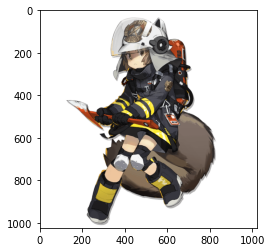

In [10]:
# Load an image
image_fullres, image = read_image("shaw.png")
plt.imshow(image_fullres)

In [11]:
# Tag image
tags = decode_tags(image)
show_tags(tags)

    rating:safe                      0.999563
    1girl                            0.993835
    weapon                           0.925944
    solo                             0.876221
    brown_hair                       0.781983
    white_background                 0.779414
    tail                             0.735622
    holding                          0.728705
    brown_eyes                       0.688665
    simple_background                0.672623
    knee_pads                        0.668363
    holding_weapon                   0.666669
    looking_at_viewer                0.660606
    gloves                           0.652506
    sword                            0.636819
    full_body                        0.631586
    helmet                           0.560873
    boots                            0.530507
    mecha_musume                     0.467351
    hat                              0.440392
    closed_mouth                     0.426577
    knife                         

In [12]:
# Calculate gradcam maps
gradcam_maps = dict(zip(list(tags.keys()), gradcam(image, list(tags.keys()), batch_size = 5, verbose = True)))
gradcam_maps_processed = dict(zip(gradcam_maps.keys(), list(map(postprocess_grads, gradcam_maps.values()))))

Batch: 0 to 5 of 55
Batch: 5 to 10 of 55
Batch: 10 to 15 of 55
Batch: 15 to 20 of 55
Batch: 20 to 25 of 55
Batch: 25 to 30 of 55
Batch: 30 to 35 of 55
Batch: 35 to 40 of 55
Batch: 40 to 45 of 55
Batch: 45 to 50 of 55
Batch: 50 to 55 of 55


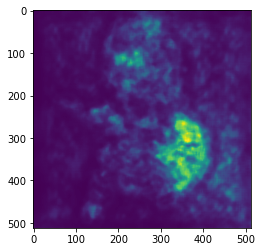

In [13]:
# Inspect one of the maps
plt.imshow(gradcam_maps_processed["tail"])

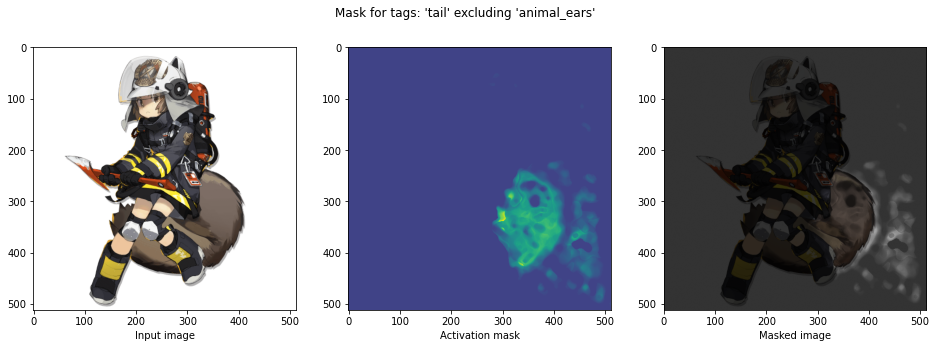

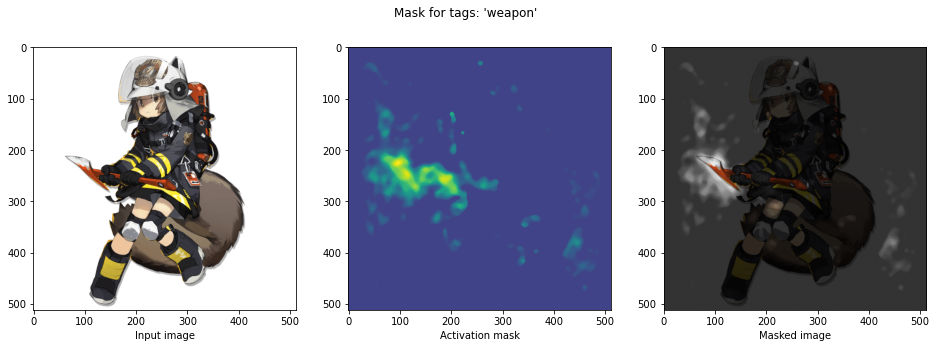

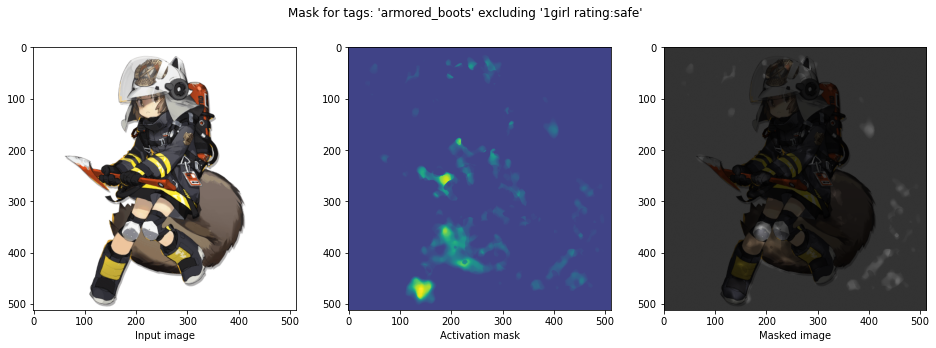

In [14]:
# Plot some maps in a nice way
plot_tags(image, gradcam_maps_processed, ["tail"], ["animal_ears"])
plot_tags(image, gradcam_maps_processed, ["weapon"])
plot_tags(image, gradcam_maps_processed, ["armored_boots"], ["1girl", "rating:safe"])

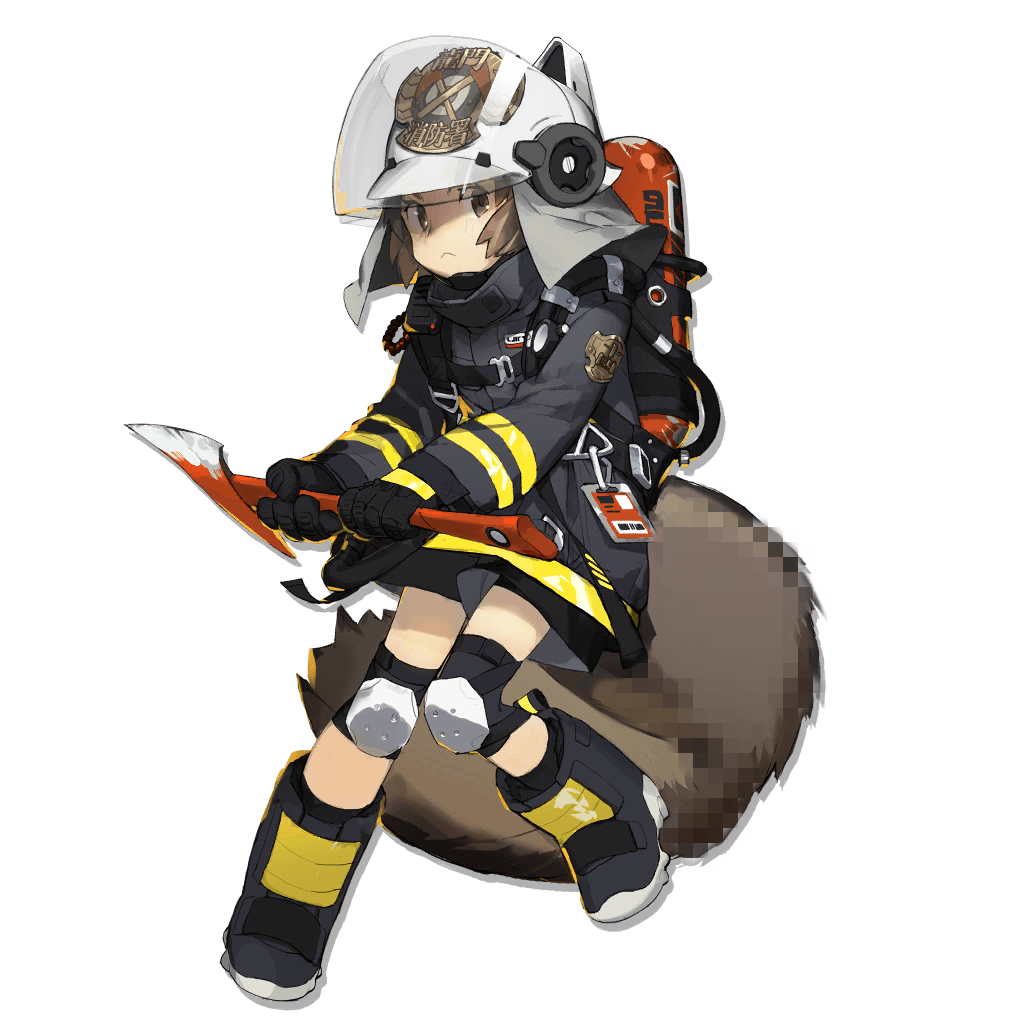

In [15]:
# Make the image SFPR (Safe For Projekt Red)
censored = mask_fullres_image(image_fullres, image, gradcam_maps_processed, ["tail"], pixelate = True)
censored

In [16]:
##
# Tags-for-images calculation for the Stylegan2-Playground notebook
##

"""
# Rudimentary watchdog so this can all run overnight
while(True):
    tags_exist = set(map(lambda x: x.split("_")[-1], glob.glob("image_tags_*")))
    tags_required = set(map(lambda x: x.split("_")[-1], glob.glob("dlatents_for_tagging_*")))
    tags_todo = sorted(list(tags_required.difference(tags_exist)))
    time.sleep(10)
    
    for tags_clean in tags_exist:
        latents, dlatents, images = pickle.load(open("dlatents_for_tagging_" + tags_clean, 'rb'))
        if len(images) > 0:
            print("Cleaning", tags_clean)
            with open("dlatents_for_tagging_" + tags_clean, 'wb') as f:
                pickle.dump([latents, dlatents, []], f)
    
    if len(tags_todo) > 0:
        for tags_do in tags_todo:
            print("Processing", tags_do)
            _, _, images_to_tag = pickle.load(open("dlatents_for_tagging_" + tags_do, 'rb'))
            batch_size = 5
            image_tags = []
            for i in range(0, len(images_to_tag), batch_size):
                tags = decode_tags(np.array(images_to_tag[i:i+batch_size]) / 255.0)
                image_tags.extend(tags)
            with open("image_tags_" + tags_do, 'wb') as f:
                pickle.dump(image_tags, f)              
    time.sleep(10)
"""    

'\n# Rudimentary watchdog so this can all run overnight\nwhile(True):\n    tags_exist = set(map(lambda x: x.split("_")[-1], glob.glob("image_tags_*")))\n    tags_required = set(map(lambda x: x.split("_")[-1], glob.glob("dlatents_for_tagging_*")))\n    tags_todo = sorted(list(tags_required.difference(tags_exist)))\n    time.sleep(10)\n    \n    for tags_clean in tags_exist:\n        latents, dlatents, images = pickle.load(open("dlatents_for_tagging_" + tags_clean, \'rb\'))\n        if len(images) > 0:\n            print("Cleaning", tags_clean)\n            with open("dlatents_for_tagging_" + tags_clean, \'wb\') as f:\n                pickle.dump([latents, dlatents, []], f)\n    \n    if len(tags_todo) > 0:\n        for tags_do in tags_todo:\n            print("Processing", tags_do)\n            _, _, images_to_tag = pickle.load(open("dlatents_for_tagging_" + tags_do, \'rb\'))\n            batch_size = 5\n            image_tags = []\n            for i in range(0, len(images_to_tag), batc

In [18]:
image = None
image_fullres = None
tags = None
gradcam_maps = None
gradcam_maps_processed = None
tag_maps = None

In [19]:
##
# Interactive tagging + gradcam visualization (by censoring images)
# Drag slider towards 1 to pixelate, towards -1 to exclude
##
tag_widgets = None
def load_image(path):
    # Load an image
    global image
    global image_fullres
    global tags
    global gradcam_maps
    global gradcam_maps_processed
    global tag_maps
    global tag_widgets
    
    image_fullres, image = read_image(path)
    
    print("Tagging...")
    tags = decode_tags(image)
    
    print("Calculating gradcam maps...")
    gradcam_maps = dict(zip(list(tags.keys()), gradcam(image, list(tags.keys()), batch_size = 5, verbose = True)))
    gradcam_maps_processed = dict(zip(gradcam_maps.keys(), list(map(postprocess_grads, gradcam_maps.values()))))
    
    print("Calculating tag maps...")
    tag_maps = {}
    for tag in gradcam_maps_processed:
        tag_map = threshold_map(gradcam_maps_processed[tag], list(gradcam_maps_processed.values()))
        tag_map = ndimage.median_filter(tag_map, 10)
        tag_map /= np.max(tag_map)
        tag_maps[tag] = tag_map
    
    tag_widgets = {}
    for tag in tags:
        tag_widgets[tag] = widgets.FloatSlider(description=tag, min = -0.99, max = 0.99, step = 0.01, value=0.0, continuous_update = False, readout = True)
    all_widgets = list(tag_widgets.values())

    reset_sliders = widgets.Button(description="Reset")
    reset_sliders.on_click(reset)
    
    load_button = widgets.Button(description="Load input.png")
    load_button.on_click(load_input)

    ui = widgets.Box(all_widgets + [reset_sliders, load_button])

    ui.layout.flex_flow = 'row wrap'
    ui.layout.display = 'inline-flex'

    out = widgets.interactive_output(censor_and_display, tag_widgets)
    clear_output(wait=True)
    display(ui, out)
    
def censor_and_display(**kwargs):
    mask = np.zeros(gradcam_maps_processed[list(gradcam_maps_processed.keys())[0]].shape)    
    for tag in kwargs:
        if kwargs[tag] > 0.0:
            mask += (tag_maps[tag] > (1.0 - kwargs[tag]))
        if kwargs[tag] < 0.0:
            mask -= (tag_maps[tag] > (1.0 + kwargs[tag]))
    mask = 1.0 - (mask > 0.0)
    mask = ndimage.morphology.binary_dilation(mask, iterations=int(5 * 1.5), border_value = 1)
    mask = ndimage.morphology.binary_erosion(mask, iterations=int(15 * 1.5), border_value = 1)
    
    mask_image = np.repeat(mask.reshape(mask.shape[0], mask.shape[1], 1), 3, axis = -1) * 255.0
    mask_image = PIL.Image.fromarray(mask_image.astype("uint8"))
    mask_image = mask_image.resize(image_fullres.size, resample = PIL.Image.LANCZOS)
    
    mask = np.array(mask_image)[:, :, 0] / 255.0
    mask = ndimage.gaussian_filter(mask, 3)

    image_fullres_arr = np.array(image_fullres)    
    masked_image = np.array(image_fullres_arr * np.repeat(mask, 3).reshape(image_fullres_arr.shape))
    
    image_fullres_pixeled = image_fullres.resize(np.array(image_fullres.size) // 15).resize(image_fullres.size, resample=PIL.Image.NEAREST)
    pixeled_arr = np.array(image_fullres_pixeled)

    pixeled_image = np.array(pixeled_arr * np.repeat(1.0 - mask, 3).reshape(image_fullres_arr.shape))
    masked_image = masked_image + pixeled_image
    
    censored = PIL.Image.fromarray(masked_image.astype("uint8"))  
    display(censored)
    
def reset(b):
    for widget in tag_widgets:
        tag_widgets[widget].value = 0.0

def load_input(b):
    load_image("input.png")
    
load_image("shaw.png")

Box(children=(FloatSlider(value=0.0, continuous_update=False, description='rating:safe', max=0.99, min=-0.99, …

Output()